In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

kaggle/input\speech-emotion-recognition-crema-and-tess\features.csv
kaggle/input\speech-emotion-recognition-en\Crema\1001_DFA_ANG_XX.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_DFA_DIS_XX.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_DFA_FEA_XX.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_DFA_HAP_XX.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_DFA_NEU_XX.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_DFA_SAD_XX.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_ANG_HI.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_ANG_LO.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_ANG_MD.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_DIS_HI.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_DIS_LO.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_DIS_MD.wav
kaggle/input\speech-emotion-recognition-en\Crema\1001_IEO_FEA_HI.wav
kaggle/input\speech-emotion-recogni

In [5]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
tess_path = "kaggle/input/speech-emotion-recognition-en/Tess"

paths = []
labels = []

for dirname, _, filenames in os.walk(tess_path):
    for filename in filenames:
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
print('Dataset is Loaded')

Dataset is Loaded


In [7]:
df = pd.DataFrame({'path':paths, 'label':labels})

In [8]:
df.head()

,path,label
0,kaggle/input/speech-emotion-recognition-en/Tes...,angry
1,kaggle/input/speech-emotion-recognition-en/Tes...,angry
2,kaggle/input/speech-emotion-recognition-en/Tes...,angry
3,kaggle/input/speech-emotion-recognition-en/Tes...,angry
4,kaggle/input/speech-emotion-recognition-en/Tes...,angry


In [9]:
df.shape

(2800, 2)

## Exploratory Data Analysis

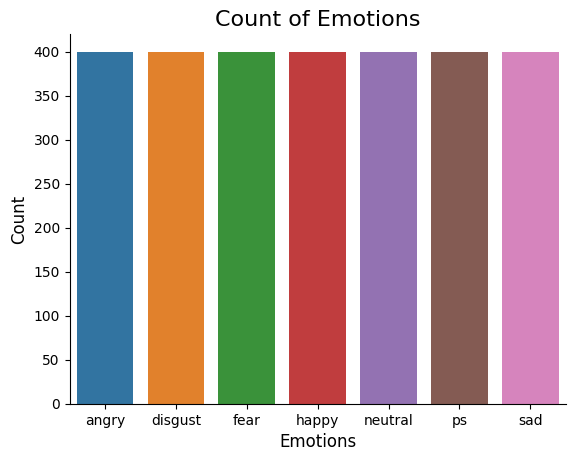

In [10]:
plt.title('Count of Emotions', size=16)
sns.countplot(data=df, x='label')
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [11]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

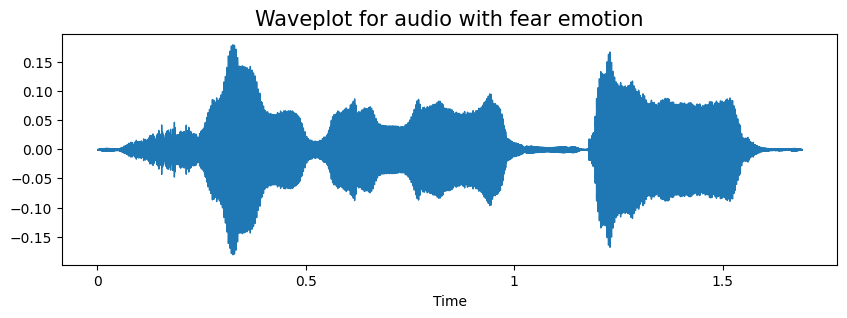

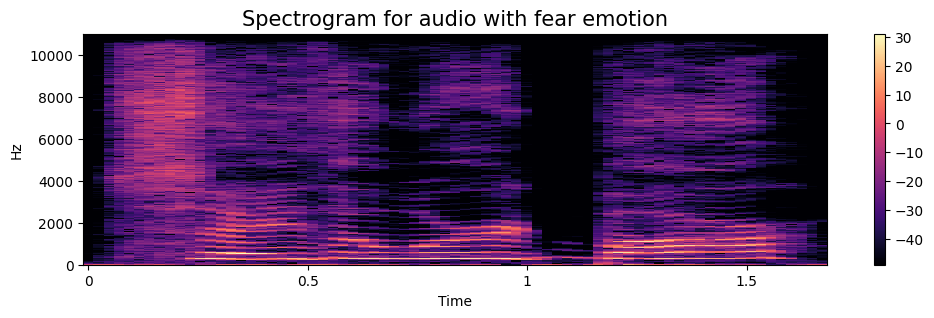

In [12]:
emotion='fear'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

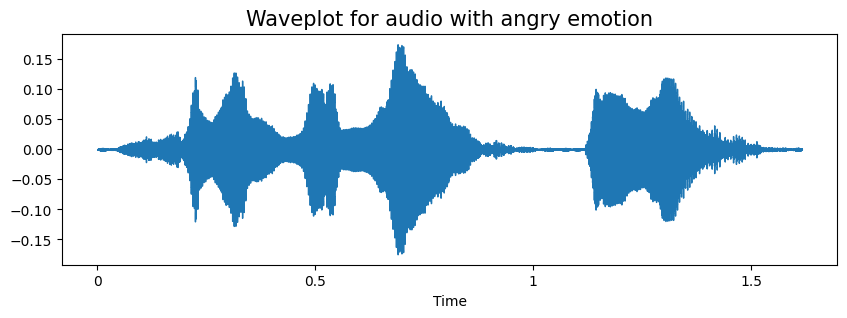

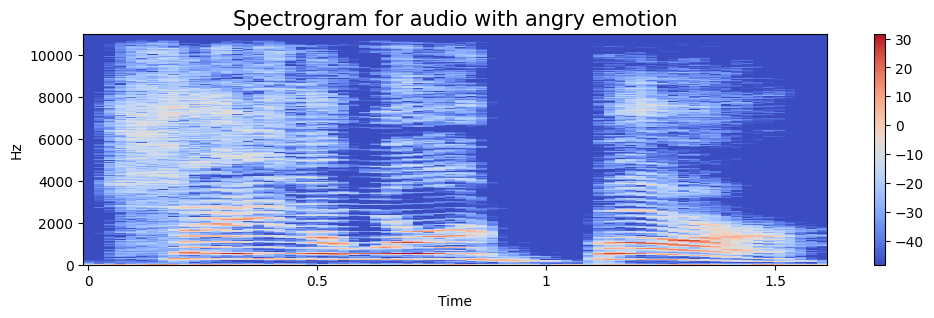

In [13]:
emotion='angry'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

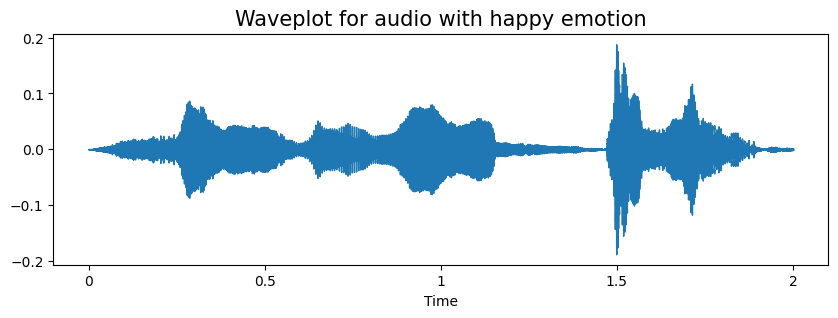

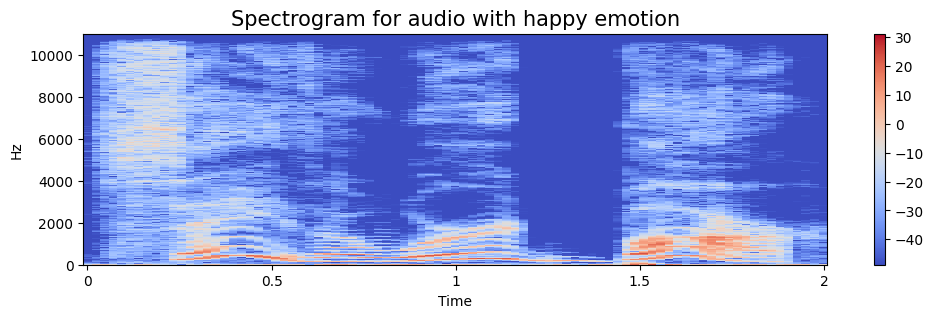

In [14]:
emotion='happy'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

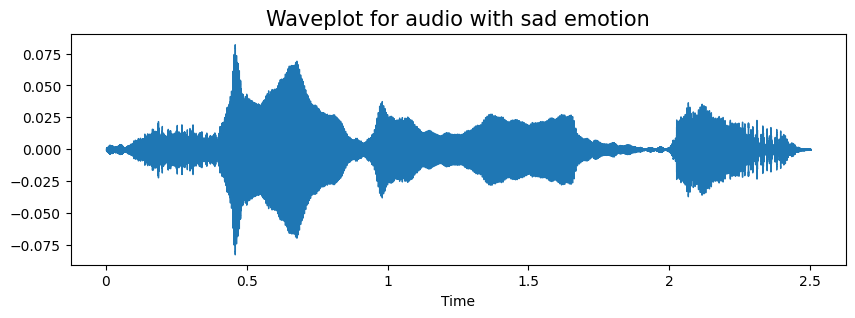

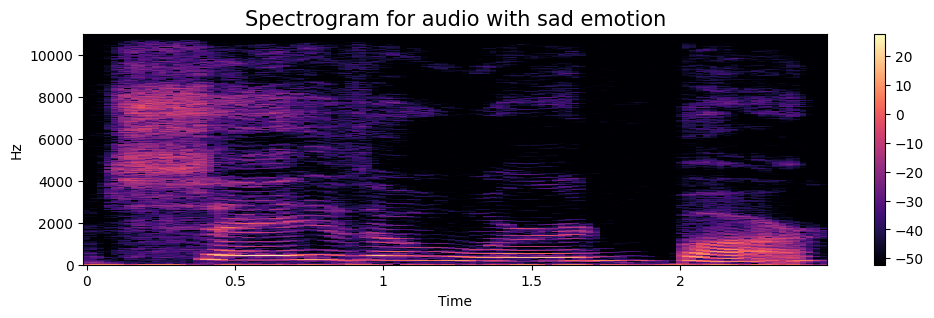

In [15]:
emotion='sad'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

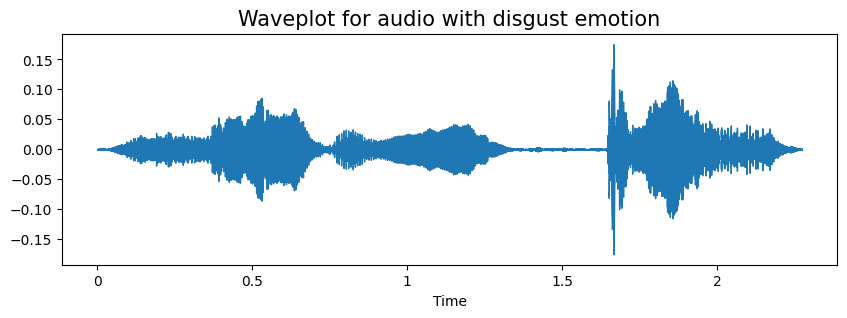

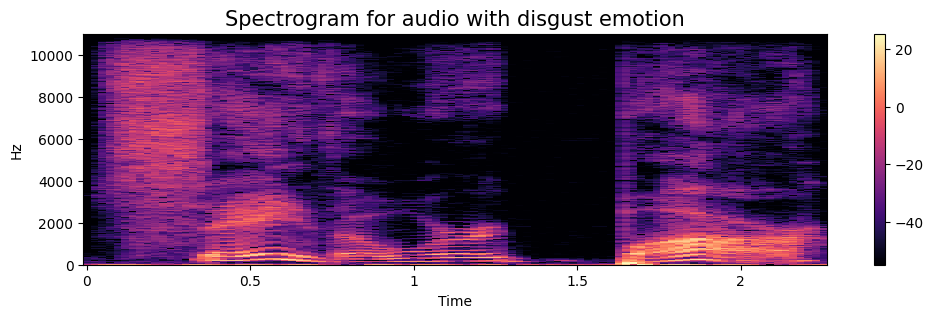

In [16]:
emotion='disgust'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

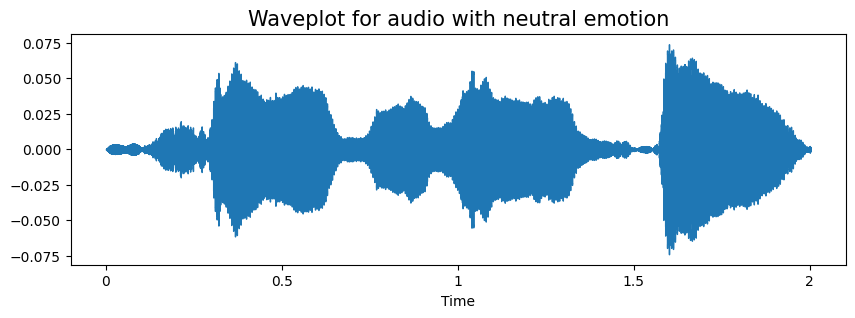

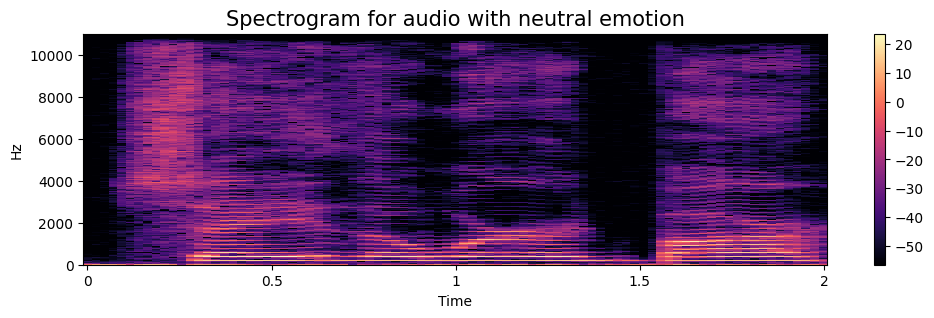

In [17]:
emotion='neutral'
path = np.array(df.path[df.label==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

In [18]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    n_steps = 12 * pitch_factor  # Assuming 12 steps per octave
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

path = np.array(df['path'])[1]
data, sample_rate = librosa.load(path)

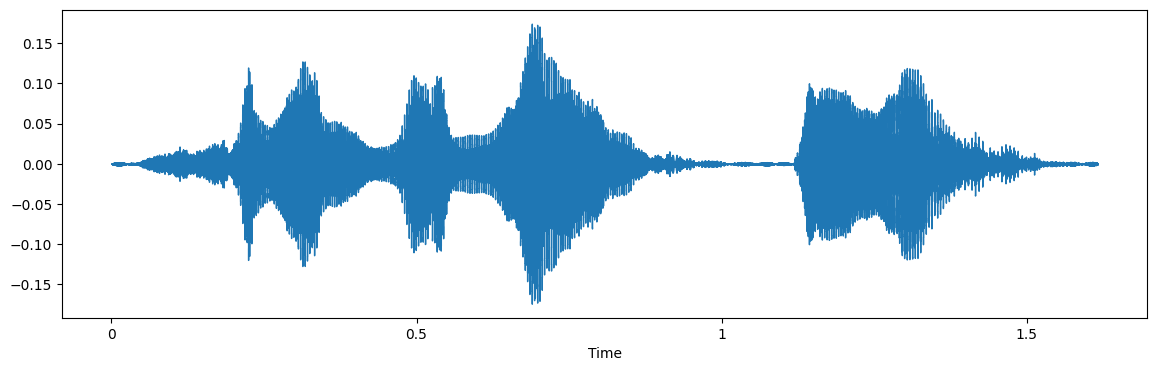

In [19]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

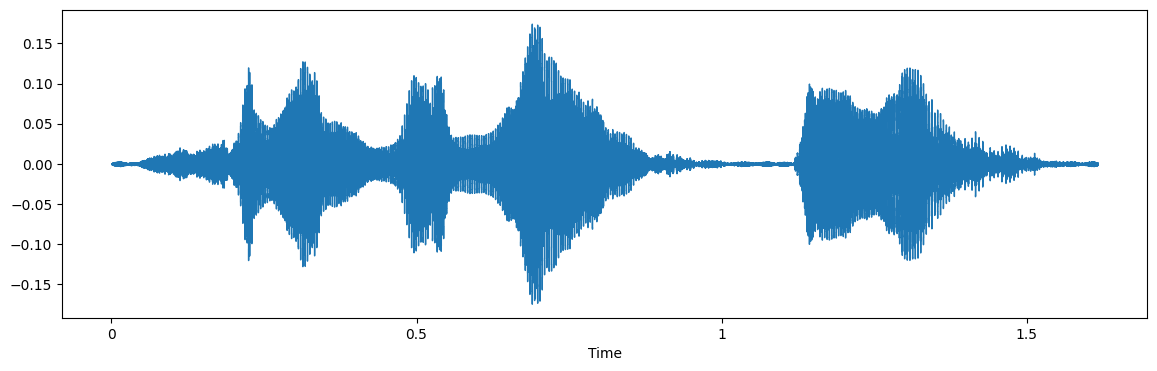

In [20]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

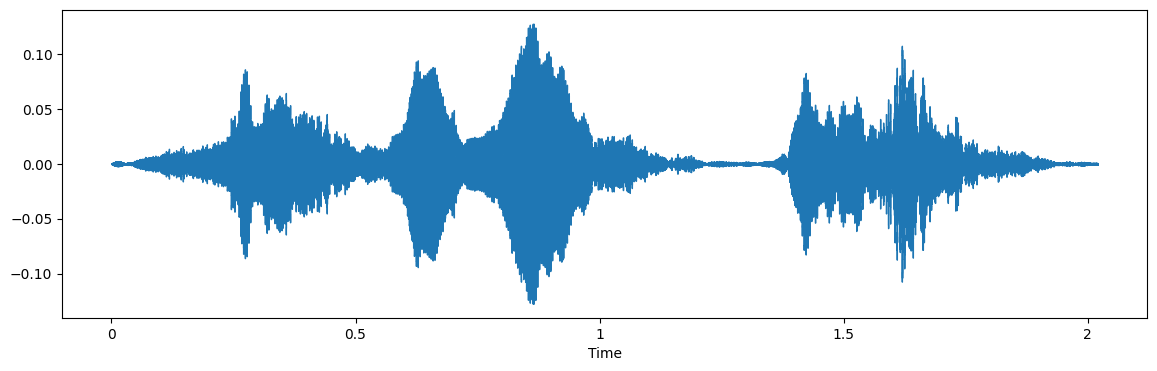

In [21]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

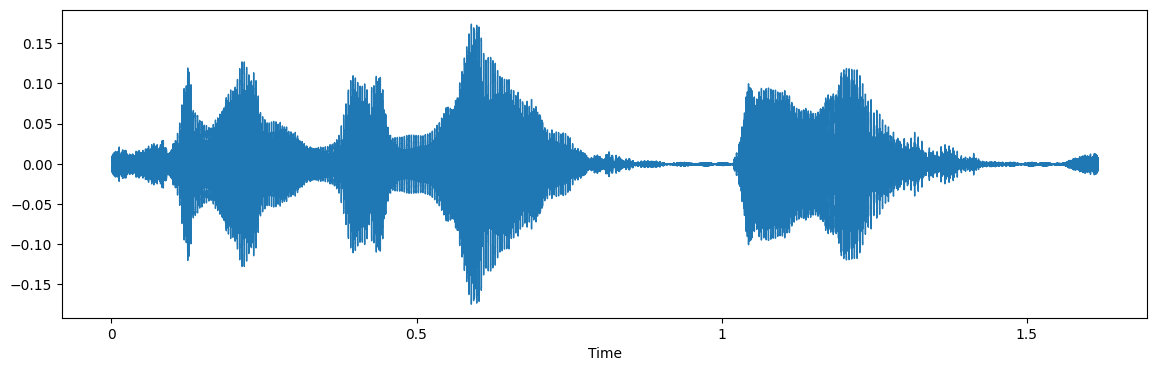

In [22]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

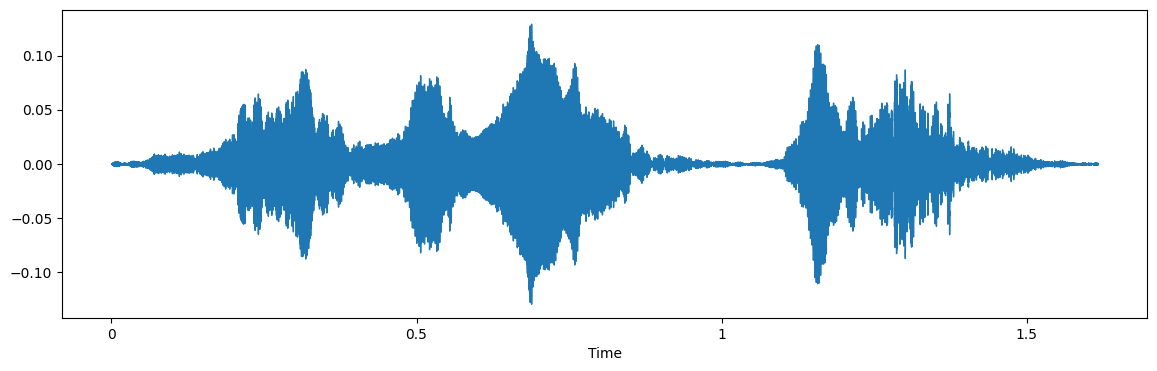

In [23]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [24]:
def extract_features(data):
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [39]:
X, Y = [], []
for path, emotion in zip(df['path'], df['label']):
    print(path, emotion)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_back_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_bar_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_base_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_bath_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_bean_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_beg_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_bite_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_boat_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_bone_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_book_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_bought_angry.wav angry
kaggle/input/speech-emotion-recognition-en/Tess\OAF_angry\OAF_burn_angry.wav angry
kagg

In [40]:
len(X), len(Y), df.path.shape

(8400, 8400, (2800,))

In [41]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Features.to_csv('features_tess.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-398.608246,75.117401,-21.772625,-19.993965,2.985435,13.788044,-19.953243,-7.025359,-5.187742,1.833246,...,1.479891,2.302237,2.201618,1.957095,1.105945,-5.587186,-4.650013,-2.491658,-9.133067,angry
1,-204.066228,22.750229,-6.327212,-12.175828,-2.569078,2.230398,-4.093918,-5.845970,-3.372255,0.522311,...,-0.720760,-0.460062,1.135241,1.438069,-1.433851,-2.974913,-2.220991,-2.722609,-5.483171,angry
2,-433.174622,45.838348,-52.567734,-5.295103,5.816264,-23.504156,2.893873,11.255117,1.060392,-0.203685,...,-9.082339,-13.384068,-2.679495,7.676686,22.347364,22.028233,26.949875,7.531269,5.129890,angry
3,-469.633392,101.032448,1.475380,-32.444489,-9.686409,14.370925,-1.291309,-5.177819,-9.246144,5.867874,...,10.429772,-1.341168,1.275015,-0.199243,-1.488937,-7.783144,-5.000467,-2.176940,-8.113317,angry
4,-316.791623,40.200907,0.384358,-16.308833,-7.766585,3.277963,1.452851,-4.106065,-5.996634,-2.512506,...,2.143318,1.182288,0.742098,0.428048,-2.851213,-4.842160,-4.223633,-2.950880,-5.466876,angry


In [25]:
# Features = pd.read_csv('/kaggle/input/speech-emotion-recognition-crema-and-tess/features.csv')
# Features.head()

## Data Preparation

In [42]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [43]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [44]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 20), (6300, 7), (2100, 20), (2100, 7))

In [45]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 20), (6300, 7), (2100, 20), (2100, 7))

In [46]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6300, 20, 1), (6300, 7), (2100, 20, 1), (2100, 7))

## Modeling

In [47]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 20, 256)           1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 10, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 10, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 5, 256)            0         
 g1D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 256)            0         
                                                                 
 conv1d_6 (Conv1D)           (None, 5, 128)           

In [48]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
99/99 [==============================] - 4s 29ms/step - loss: 1.7205 - accuracy: 0.2843 - val_loss: 1.2658 - val_accuracy: 0.5214 - lr: 0.0010
Epoch 2/50
99/99 [==============================] - 3s 27ms/step - loss: 1.1921 - accuracy: 0.5330 - val_loss: 0.8568 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 3/50
99/99 [==============================] - 3s 27ms/step - loss: 0.8339 - accuracy: 0.6930 - val_loss: 0.5587 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 4/50
99/99 [==============================] - 3s 26ms/step - loss: 0.6159 - accuracy: 0.7883 - val_loss: 0.4388 - val_accuracy: 0.8300 - lr: 0.0010
Epoch 5/50
99/99 [==============================] - 3s 26ms/step - loss: 0.4987 - accuracy: 0.8302 - val_loss: 0.3914 - val_accuracy: 0.8648 - lr: 0.0010
Epoch 6/50
99/99 [==============================] - 3s 28ms/step - loss: 0.4105 - accuracy: 0.8663 - val_loss: 0.2347 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 7/50
99/99 [==============================] - 3s 28ms/step - loss: 0.3

66/66 [==============================] - 0s 4ms/step - loss: 0.1173 - accuracy: 0.9648
Accuracy of our model on test data :  96.47619128227234 %


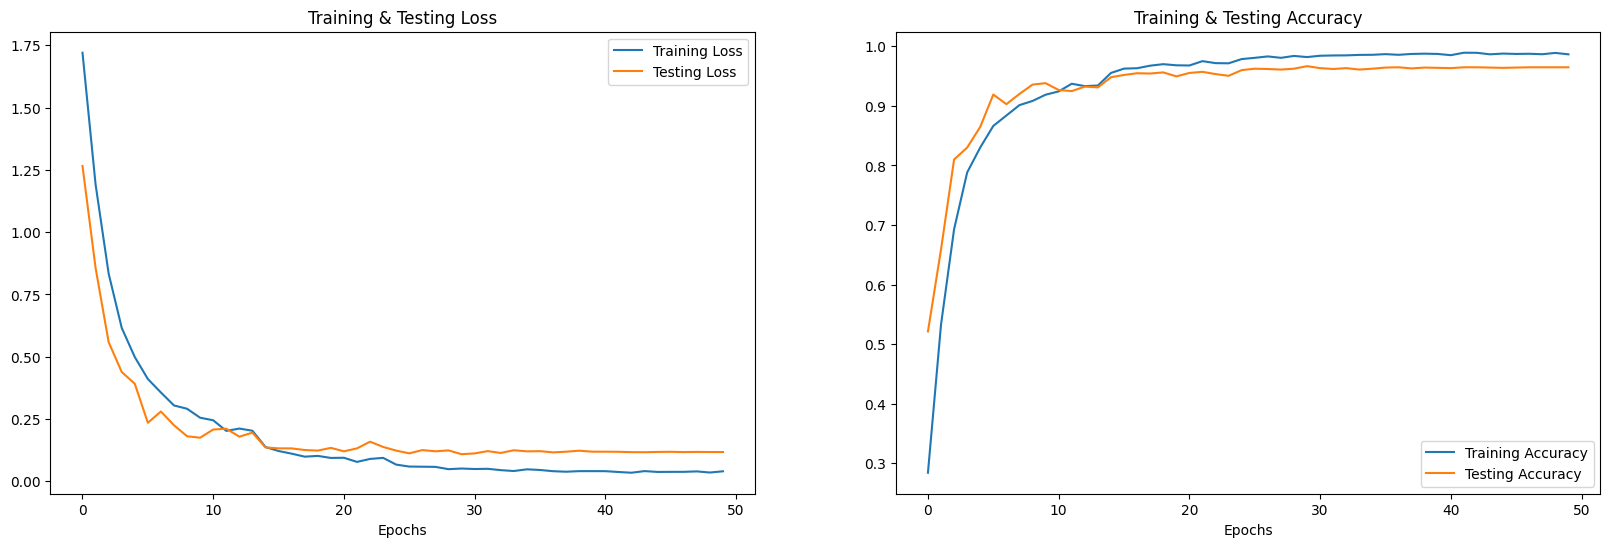

In [49]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [50]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

66/66 [==============================] - 0s 4ms/step


In [51]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,ps,ps
2,neutral,neutral
3,happy,happy
4,happy,ps
5,fear,fear
6,fear,fear
7,sad,sad
8,disgust,disgust
9,fear,fear


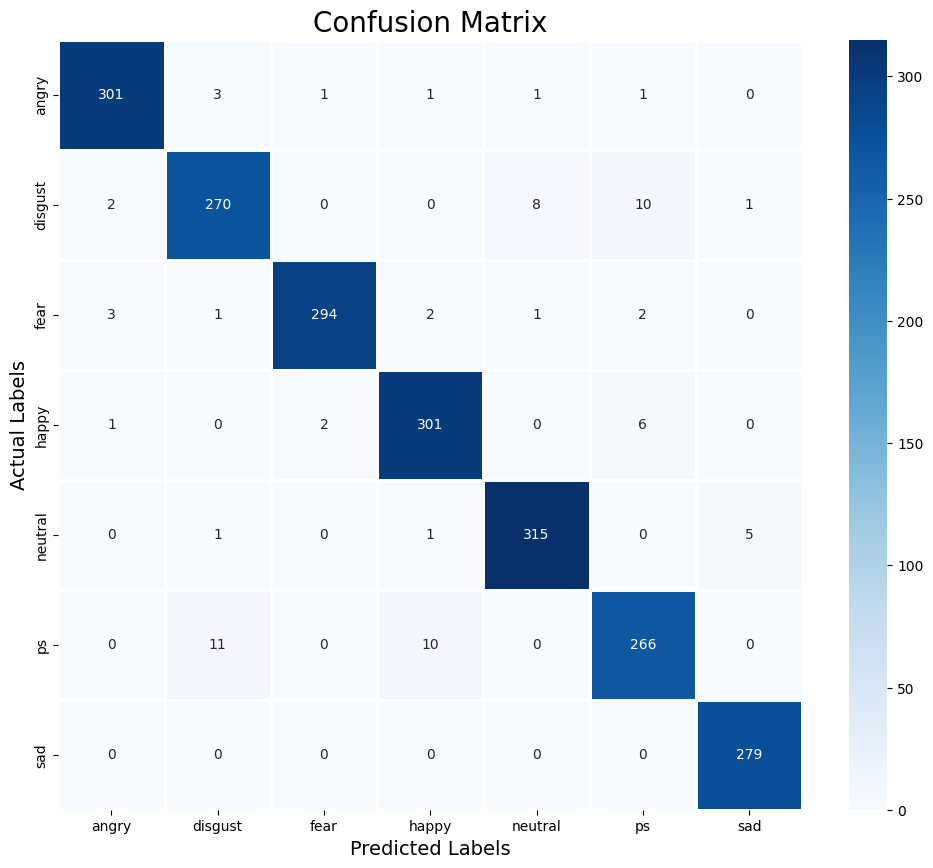

In [52]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.98      0.98      0.98       308
     disgust       0.94      0.93      0.94       291
        fear       0.99      0.97      0.98       303
       happy       0.96      0.97      0.96       310
     neutral       0.97      0.98      0.97       322
          ps       0.93      0.93      0.93       287
         sad       0.98      1.00      0.99       279

    accuracy                           0.96      2100
   macro avg       0.96      0.96      0.96      2100
weighted avg       0.96      0.96      0.96      2100



In [54]:
model.save('my_model.h5')